# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.71KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

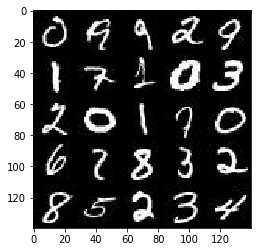

In [33]:
data_dir = './data'
import helper
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

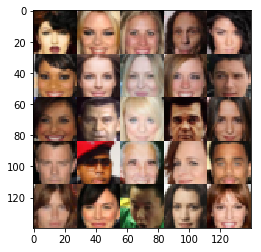

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [36]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_rate = tf.placeholder(tf.float32, (None), name='learn_rate')

    return (inputs_real, inputs_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [37]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(3/1)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu1, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [38]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [39]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [40]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
class GAN:
    def __init__(self, img_shape, z_dim, learning_rate, beta1):
        tf.reset_default_graph()
        self.input_real, self.input_z, lr = model_inputs(img_shape[0], img_shape[1], img_shape[2], z_dim)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, img_shape[2])
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    net = GAN(data_shape[1:4], z_dim, learning_rate, beta1)
    saver = tf.train.Saver()
    print_every = 100
    steps = 0
    n_images = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #fix the scale in the source images
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % print_every == 0:
                    show_generator_output(sess, n_images, net.input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.4925
Epoch 1/2... Discriminator Loss: 1.4355... Generator Loss: 0.5386
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.6028
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.6372
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.6580
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.6385


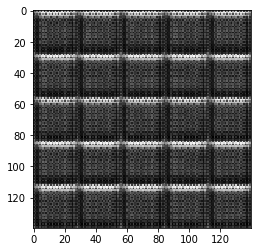

Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.6106
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.6344
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.6549


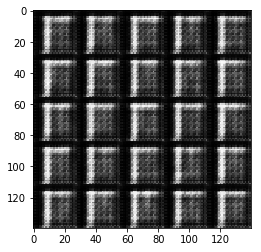

Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6837


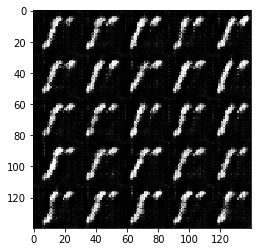

Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.6746
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.6771
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.6760


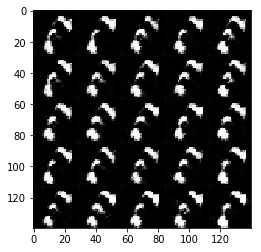

Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.6674
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.6898


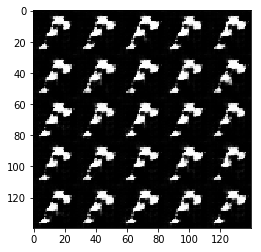

Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.7043
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.7001
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6839


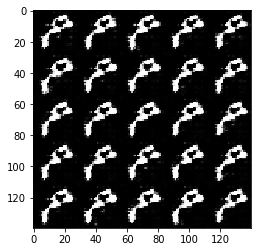

Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.6555
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.6763


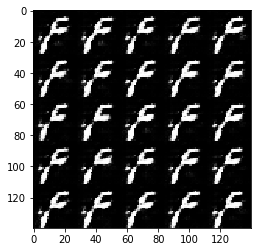

Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.6505
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.6799
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.7131


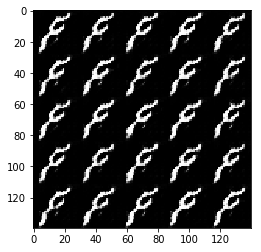

Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.3892... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.6819


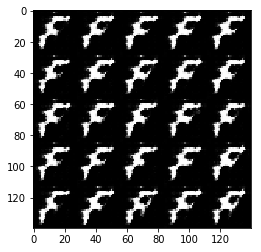

Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.7069
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.6168
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.6806


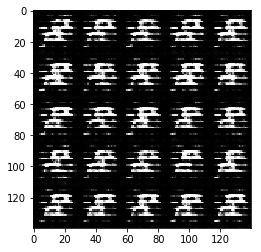

Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.6658
Epoch 1/2... Discriminator Loss: 1.3892... Generator Loss: 0.7149
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.6947


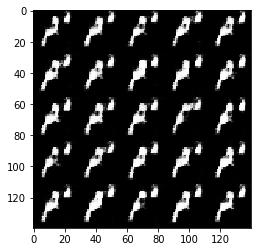

Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7062


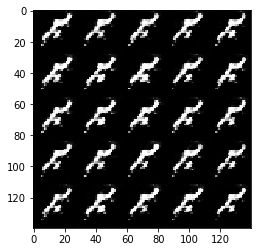

Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.6623
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.6714
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.7336


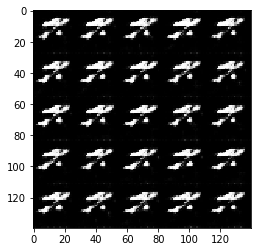

Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.6552
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6933


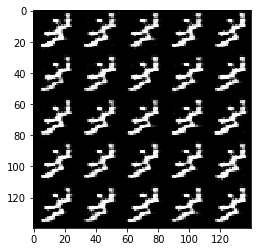

Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.6746
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7008


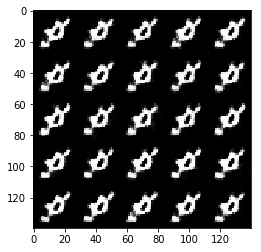

Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.6969


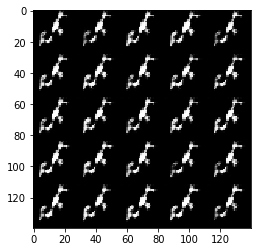

Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.6296


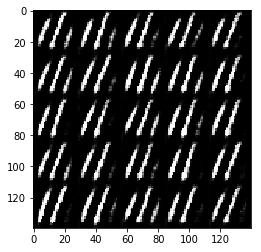

Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.5442
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6561
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.6781
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.6736
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.6642


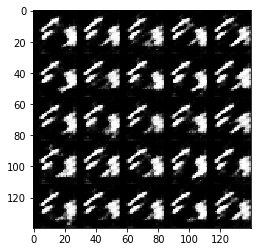

Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.6847
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.7020
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.7206


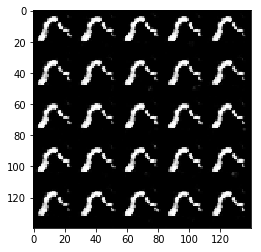

Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7004


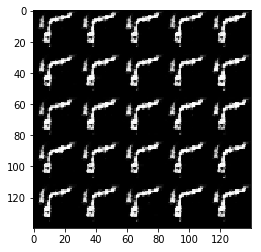

Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.6743
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6837


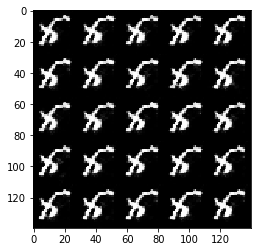

Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.6966
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.6887


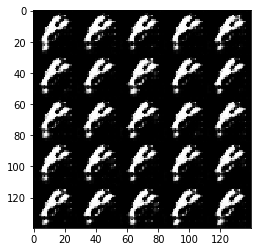

Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.7021
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7005
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.6961


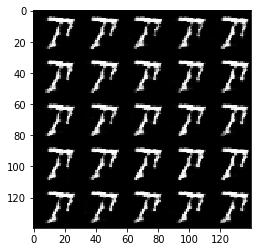

Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.7027


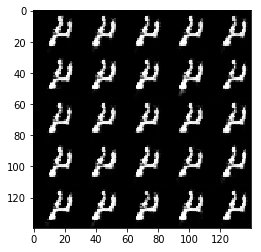

Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.6892
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.6596
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.6912


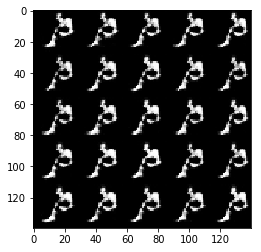

Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.6995


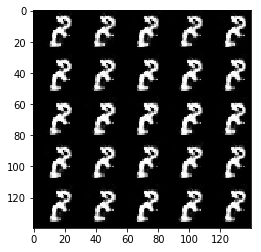

Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.7009
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.7106
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.7043


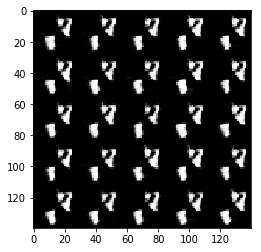

Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6559
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.7426


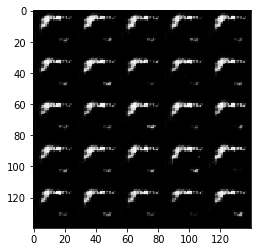

Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.6913
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.7000


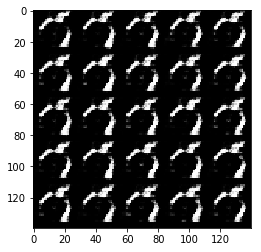

Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.7258
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.6793


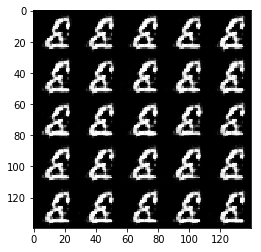

Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.7133


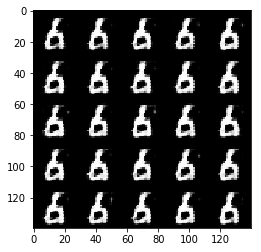

Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 0.6933
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.6867


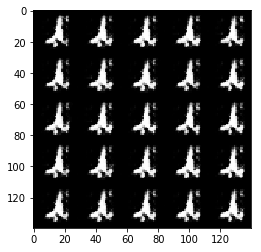

Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.6812
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.6820


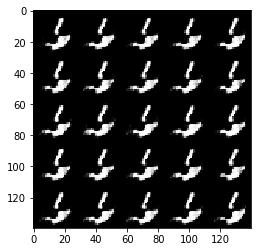

Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.6766
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.6831
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.7606


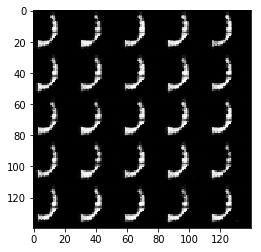

Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.6834


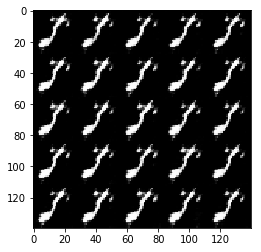

Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.7069
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.6641
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.7132


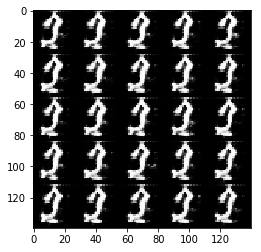

Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.6753
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.6770


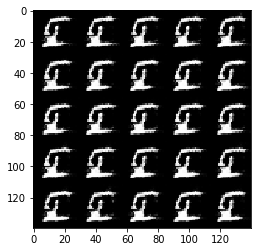

Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.7145
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.6966
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.6932


IndexError: list index out of range

In [45]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.